In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224,224)
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape = IMAGE_SHAPE+(3,))
])

In [3]:
import requests
from io import BytesIO

url = '''https://5.imimg.com/data5/SELLER/Default/2020/11/HB/JG/NQ/101302946/wood-spoon-500x500.jpg'''
response = requests.get(url)
img = Image.open(BytesIO(response.content))

In [4]:
image_to_predict = img.resize(IMAGE_SHAPE)

In [5]:
image_to_predict = np.array(image_to_predict)/255.0
image_to_predict.shape

(224, 224, 3)

In [6]:
final_img = image_to_predict[np.newaxis,...]
final_img.shape

(1, 224, 224, 3)

In [7]:
result = model.predict(final_img)

1/1 [==============================] - 2s 2s/step


In [8]:
predicted_label_index = np.argmax(result)
predicted_label_index 

911

In [9]:
image_labels = []
with open("ImageNetLabels.txt") as f:
  image_labels = f.read().splitlines()

In [10]:
image_labels[predicted_label_index]

'wooden spoon'

In [11]:
import pathlib
data_dir = pathlib.Path("train")

In [12]:
len(list(data_dir.glob("*/*.jpg")))

2855

In [13]:
import os
data_labels = []
rootdir = 'train/'
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file)
    if os.path.isdir(d):
        data_labels.append(d[6:])

In [14]:
data_labels

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [15]:
','.join(data_labels)

'apple,banana,beetroot,bell pepper,cabbage,capsicum,carrot,cauliflower,chilli pepper,corn,cucumber,eggplant,garlic,ginger,grapes,jalepeno,kiwi,lemon,lettuce,mango,onion,orange,paprika,pear,peas,pineapple,pomegranate,potato,raddish,soy beans,spinach,sweetcorn,sweetpotato,tomato,turnip,watermelon'

In [16]:
fnv_images_dict = {}
for label in data_labels:
    fnv_images_dict[label] = list(data_dir.glob(f"{label}/*"))

In [ ]:
fnv_images_dict['apple']

In [18]:
fnv_labels_dict = {}
for index,label in enumerate(data_labels):
    fnv_labels_dict[label] = index

In [19]:
fnv_labels_dict

{'apple': 0,
 'banana': 1,
 'beetroot': 2,
 'bell pepper': 3,
 'cabbage': 4,
 'capsicum': 5,
 'carrot': 6,
 'cauliflower': 7,
 'chilli pepper': 8,
 'corn': 9,
 'cucumber': 10,
 'eggplant': 11,
 'garlic': 12,
 'ginger': 13,
 'grapes': 14,
 'jalepeno': 15,
 'kiwi': 16,
 'lemon': 17,
 'lettuce': 18,
 'mango': 19,
 'onion': 20,
 'orange': 21,
 'paprika': 22,
 'pear': 23,
 'peas': 24,
 'pineapple': 25,
 'pomegranate': 26,
 'potato': 27,
 'raddish': 28,
 'soy beans': 29,
 'spinach': 30,
 'sweetcorn': 31,
 'sweetpotato': 32,
 'tomato': 33,
 'turnip': 34,
 'watermelon': 35}

In [20]:
X,y = [],[]

for label_name,images in fnv_images_dict.items():
    for image in images:
        try:
            img = cv2.imread(str(image))
            resized_img = cv2.resize(img,IMAGE_SHAPE)
            X.append(resized_img)
            y.append(fnv_labels_dict[label_name])
        except Exception as e:
            print(str(e))

OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [21]:
X = np.array(X)
y = np.array(y)

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [23]:
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0

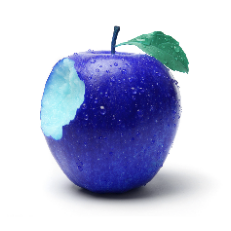

In [24]:
plt.axis('off')
plt.imshow(X[0]);

In [25]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
transfer_learning_model_without_top_layer = hub.KerasLayer(feature_extractor_model, input_shape = (224,224,3),
                   trainable=False)

In [26]:
num_of_labels = len(data_labels)
model = tf.keras.Sequential([
    transfer_learning_model_without_top_layer,
    tf.keras.layers.Dense(num_of_labels)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 36)                46116     
                                                                 
Total params: 2,304,100
Trainable params: 46,116
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc'])
model.fit(X_train_scaled,y_train,epochs = 5)

Epoch 1/5
78/78 [==============================] - 155s 2s/step - loss: 2.1987 - acc: 0.4332
Epoch 2/5
78/78 [==============================] - 135s 2s/step - loss: 0.8745 - acc: 0.7760
Epoch 3/5
78/78 [==============================] - 127s 2s/step - loss: 0.6004 - acc: 0.8543
Epoch 4/5
78/78 [==============================] - 125s 2s/step - loss: 0.4382 - acc: 0.8972
Epoch 5/5
78/78 [==============================] - 132s 2s/step - loss: 0.3371 - acc: 0.9310


In [28]:
url = '''https://cdn-prod.medicalnewstoday.com/content/images/articles/271/271157/bananas-chopped-up-in-a-bowl.jpg'''
response = requests.get(url)
img = Image.open(BytesIO(response.content))


image_to_predict = img.resize(IMAGE_SHAPE)
image_to_predict = np.array(image_to_predict)/255.0
final_img = image_to_predict[np.newaxis,...]
result = model.predict(final_img)
predicted_label_index = np.argmax(result)

data_labels[predicted_label_index]

1/1 [==============================] - 2s 2s/step


'banana'

In [2]:
!pip install BeautifulSoup4

     -------------------------------------- 128.2/128.2 KB 3.7 MB/s eta 0:00:00


You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


# Web scraping for Custom dataset 

In [3]:
import os
import requests
from bs4 import BeautifulSoup

In [4]:
google_image = "https://www.google.com/search?site=&tbm=isch&source=hp&biw=1873&bih=990&"

user_agent = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36"
}

In [5]:
saved_folder = 'dataset'


def main():
    if not os.path.exists(saved_folder):
        os.mkdir(saved_folder)
    download_images()

In [15]:
classes = ['door','spoon','swimming pool','keys','watch']
def download_images():
    for data in classes:
        n_images = 100
        folder_path = "/dataset/"+data
        if not os.path.exists(folder_path):
            os.mkdir(folder_path)

        print(f'searching for {data}...')

        search_url = google_image + 'q=' + data

        response = requests.get(search_url, headers=user_agent)

        html = response.text

        soup = BeautifulSoup(html, 'html.parser')

        results = soup.findAll('img', {'class': 'rg_i Q4LuWd'})

        count = 1
        links = []
        for result in results:
            try:
                link = result['data-src']
                links.append(link)
                count += 1
                if(count > n_images):
                    break

            except KeyError:
                continue

        print(f"Downloading {len(links)} images...")

        for i, link in enumerate(links):
            response = requests.get(link)

            image_name = folder_path + '/' + data + str(i+1) + '.jpg'

            with open(image_name, 'wb') as fh:
                fh.write(response.content)